## Compare the trained models
Load the checkpoints, get the test datamodel up and running, access the two channel output.

In [2]:
import torch
from mimo.models.mimo_unet import MimoUnetModel
from mimo.tasks.sen12tp.sen12tp_datamodule import get_datamodule
import matplotlib.pyplot as plt
import numpy as np

### First, load up the Gaussian model ('MIMO_NDVI_Prediction_Gauss')

In [3]:
args = {
    'seed': 1,
    'checkpoint_path': 'MIMO_NDVI_Prediction_Gauss/1yt2l40t/checkpoints/last.ckpt',
    'dataset_dir': '/deepskieslab/rnevin/zenodo_data',
    'batch_size': 32,
    'num_loss_function_params': 2,
    'num_subnetworks': 2,
    'filter_base_count': 30,
    'center_dropout_rate': 0.1,
    'final_dropout_rate': 0.1,
    'encoder_dropout_rate': 0.0,
    'core_dropout_rate': 0.0,
    'decoder_dropout_rate': 0.0,
    'loss_buffer_size': 10,
    'loss_buffer_temperature': 0.3,
    'input_repetition_probability': 0.0,
    'batch_repetitions': 1,
    'patch_size': 256,
    'stride': 249,
    'loss': 'gaussian_nll',  # Adjust based on your actual loss function
    'weight_decay': 0.0001,
    'learning_rate': 0.0001,
    'num_workers': 30,
    'training_set_percentage': 1.0,
}

args["input"] = ["VV_sigma0", "VH_sigma0"]
args["target"] = ["NDVI"]  # Example target

'''
python scripts/train/train_ndvi.py   --max_epochs 40   --batch_size 32   -t NDVI   -i VV_sigma0   -i VH_sigma0   --project "MIMO_NDVI_Prediction_Gauss"
'''

from argparse import Namespace

args = Namespace(**args)  # Convert dictionary to Namespace
dm = get_datamodule(args)



# Instantiate the model (ensure to use the same parameters as during training)
model = MimoUnetModel(
    in_channels=len(dm.model_inputs),
    out_channels=len(dm.model_targets) * args.num_loss_function_params,
    num_subnetworks=args.num_subnetworks,
    filter_base_count=args.filter_base_count,
    center_dropout_rate=args.center_dropout_rate,
    final_dropout_rate=args.final_dropout_rate,
    encoder_dropout_rate=args.encoder_dropout_rate,
    core_dropout_rate=args.core_dropout_rate,
    decoder_dropout_rate=args.decoder_dropout_rate,
    loss_buffer_size=args.loss_buffer_size,
    loss_buffer_temperature=args.loss_buffer_temperature,
    input_repetition_probability=args.input_repetition_probability,
    batch_repetitions=args.batch_repetitions,
    loss=args.loss,
    weight_decay=args.weight_decay,
    learning_rate=args.learning_rate,
    seed=args.seed,
)



In [4]:
# this is a necessary step because it adds extra prefix from the wrapper
model.compile()

In [6]:
print(args)
# Load the checkpoint
checkpoint = torch.load(args.checkpoint_path, map_location=torch.device('cpu'))
print(checkpoint.keys())
model.load_state_dict(checkpoint['state_dict'])

# Set the model to evaluation mode
model.eval()

print(model)

Namespace(seed=1, checkpoint_path='MIMO_NDVI_Prediction_Gauss/1yt2l40t/checkpoints/last.ckpt', dataset_dir='/deepskieslab/rnevin/zenodo_data', batch_size=32, num_loss_function_params=2, num_subnetworks=2, filter_base_count=30, center_dropout_rate=0.1, final_dropout_rate=0.1, encoder_dropout_rate=0.0, core_dropout_rate=0.0, decoder_dropout_rate=0.0, loss_buffer_size=10, loss_buffer_temperature=0.3, input_repetition_probability=0.0, batch_repetitions=1, patch_size=256, stride=249, loss='gaussian_nll', weight_decay=0.0001, learning_rate=0.0001, num_workers=30, training_set_percentage=1.0, input=['VV_sigma0', 'VH_sigma0'], target=['NDVI'])


/tmp/ipykernel_753/3285341536.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.checkpoint_path, map_location=torch.device('cpu'))


dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'MixedPrecision', 'hparams_name', 'hyper_parameters'])
MimoUnetModel(
  (loss_fn): GaussianNLL()
  (model): OptimizedModule(
    (_orig_mod): MimoUNet(
      (encoder): SubnetworkEncoder(
        (in_convs): ModuleList(
          (0-1): 2 x DoubleConv(
            (double_conv): Sequential(
              (0): Conv2d(2, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
              (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
              (3): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
              (4): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (5): ReLU(inplace=True)
              (6): Dropout2d(p=0.0, inplace=False)
            )
          )
       

In [8]:
print("Checkpoint state dict keys:")
print(checkpoint['state_dict'].keys())

print("\nModel state dict keys:")
print(model.state_dict().keys())

Checkpoint state dict keys:


TypeError: 'odict_keys' object is not subscriptable

In [24]:
print(len(dm.model_inputs))

2


In [13]:

# Now we can use the model to make predictions
test_data = dm.test_dataloader()  # Ensure the dataloader is set up for your test dataset

print(test_data)

torch.Size([32, 2, 2, 256, 256])
(2, 32, 2, 1, 256, 256)
<class 'tuple'>


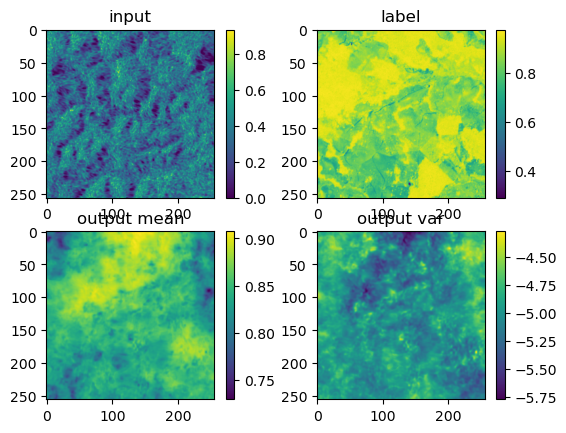

NameError: name 'STOP' is not defined

In [35]:
# Make predictions
predictions = []
with torch.no_grad():
    for inputs in test_data:
        image_tensor = inputs["image"]  # Extract the tensor
        label_tensor = inputs["label"]

        image_tensor = image_tensor.unsqueeze(1) # adding subnetwork channel
        # (B, S, C, H, W) = x.shape
        # batch, # subnetworks, channels, height, width
        
        # now duplicate, this saves on memory
        image_tensor = image_tensor.expand(-1, 2, -1, -1, -1)
        # this is the option that creates actual copies
        # image_tensor = image_tensor.repeat(1, 2, 1, 1, 1)
        print(np.shape(image_tensor))
        fig = plt.figure()
        ax0 = fig.add_subplot(221)
        im0 = ax0.imshow(image_tensor[1,0,0,:,:])
        plt.colorbar(im0)
        ax0.set_title('input')

        ax1 = fig.add_subplot(222)
        im1 = ax1.imshow(label_tensor[0,0,:,:])
        plt.colorbar(im1)
        ax1.set_title('label')
        
        
        outputs = model(image_tensor)  # Pass only the tensor to the model
        print(np.shape(outputs))
        print(type(outputs))

        output_mean = outputs[0]
        output_var = outputs[1]
        
        mean = output_mean[0, 0, 0, :, :].cpu().detach().numpy()
        var = output_var[0, 0, 0, :, :].cpu().detach().numpy()

        ax2 = fig.add_subplot(223)
        im2 = ax2.imshow(mean)
        plt.colorbar(im2)
        ax2.set_title('output mean')

        ax3 = fig.add_subplot(224)
        im3 = ax3.imshow(var)
        plt.colorbar(im3)
        ax3.set_title('output var')
        plt.show()

        # make an image for if this is well calibrated
        STOP
        
        predictions.append(outputs)

# Optionally save the predictions (or process them further)
for i, pred in enumerate(predictions):
    save_image(pred, f'prediction_{i}.png')  # Replace with actual saving function if needed



### Second, load up the Laplacian model ('MIMO NDVI Prediction')